# SSD300 Inference Tutorial

This is a brief tutorial that shows how to use a trained SSD300 for inference on the Pascal VOC datasets. If you'd like more detailed explanations, please refer to [`ssd300_training.ipynb`](https://github.com/pierluigiferrari/ssd_keras/blob/master/ssd300_training.ipynb)

In [1]:
from keras import backend as K
from keras.models import load_model
from keras.preprocessing import image
from keras.optimizers import Adam
from imageio import imread
import numpy as np
import matplotlib.patches as patches
from matplotlib import pyplot as plt

from models.keras_ssd300 import ssd_300
from models.keras_ssd512 import ssd_512
from keras_loss_function.keras_ssd_loss import SSDLoss
from keras_layers.keras_layer_AnchorBoxes import AnchorBoxes
from keras_layers.keras_layer_DecodeDetections import DecodeDetections
from keras_layers.keras_layer_DecodeDetectionsFast import DecodeDetectionsFast
from keras_layers.keras_layer_L2Normalization import L2Normalization

from ssd_encoder_decoder.ssd_output_decoder import decode_detections, decode_detections_fast

from data_generator.object_detection_2d_data_generator import DataGenerator
from data_generator.object_detection_2d_photometric_ops import ConvertTo3Channels
from data_generator.object_detection_2d_geometric_ops import Resize
from data_generator.object_detection_2d_misc_utils import apply_inverse_transforms

from extra_files import helper

%matplotlib inline

/home/aldopedraza/anaconda3/envs/tensorflow/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/home/aldopedraza/anaconda3/envs/tensorflow/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/aldopedraza/anaconda3/envs/tensorflow/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/aldopedraza/Documentos/ssd/data_generator/object_detection_2d_data_generator.py:43: UserWarning: 'BeautifulSoup' module is missing. The XML-parser will be unavailable.
  warnings.warn("'BeautifulSoup' module

## 1. Load a trained SSD

Either load a trained model or build a model and load trained weights into it. Since the HDF5 files I'm providing contain only the weights for the various SSD versions, not the complete models, you'll have to go with the latter option when using this implementation for the first time. You can then of course save the model and next time load the full model directly, without having to build it.

You can find the download links to all the trained model weights in the README.

### 1.1. Build the model and load trained weights into it

In [2]:
def load_model(model_path, height, width):
    # 1: Build the Keras model
    K.clear_session() # Clear previous models from memory.

    if height == 300:
        model = ssd_300(image_size=(height, width, 3),
                        n_classes=20,
                        mode='inference',
                        l2_regularization=0.0005,
                        scales=[0.1, 0.2, 0.37, 0.54, 0.71, 0.88, 1.05], # The scales for MS COCO are [0.07, 0.15, 0.33, 0.51, 0.69, 0.87, 1.05]
                        aspect_ratios_per_layer=[[1.0, 2.0, 0.5],
                                                 [1.0, 2.0, 0.5, 3.0, 1.0/3.0],
                                                 [1.0, 2.0, 0.5, 3.0, 1.0/3.0],
                                                 [1.0, 2.0, 0.5, 3.0, 1.0/3.0],
                                                 [1.0, 2.0, 0.5],
                                                 [1.0, 2.0, 0.5]],
                        two_boxes_for_ar1=True,
                        steps=[8, 16, 32, 64, 100, 300],
                        offsets=[0.5, 0.5, 0.5, 0.5, 0.5, 0.5],
                        clip_boxes=False,
                        variances=[0.1, 0.1, 0.2, 0.2],
                        normalize_coords=True,
                        subtract_mean=[123, 117, 104],
                        swap_channels=[2, 1, 0],
                        confidence_thresh=0.5,
                        iou_threshold=0.45,
                        top_k=200,
                        nms_max_output_size=400)
    elif height == 512:
        model = ssd_512(image_size=(height, width, 3),
                n_classes=20,
                mode='inference',
                l2_regularization=0.0005,
                scales=[0.07, 0.15, 0.3, 0.45, 0.6, 0.75, 0.9, 1.05], # The scales for MS COCO are [0.04, 0.1, 0.26, 0.42, 0.58, 0.74, 0.9, 1.06]
                aspect_ratios_per_layer=[[1.0, 2.0, 0.5],
                                         [1.0, 2.0, 0.5, 3.0, 1.0/3.0],
                                         [1.0, 2.0, 0.5, 3.0, 1.0/3.0],
                                         [1.0, 2.0, 0.5, 3.0, 1.0/3.0],
                                         [1.0, 2.0, 0.5, 3.0, 1.0/3.0],
                                         [1.0, 2.0, 0.5],
                                         [1.0, 2.0, 0.5]],
               two_boxes_for_ar1=True,
               steps=[8, 16, 32, 64, 128, 256, 512],
               offsets=[0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5],
               clip_boxes=False,
               variances=[0.1, 0.1, 0.2, 0.2],
               normalize_coords=True,
               subtract_mean=[123, 117, 104],
               swap_channels=[2, 1, 0],
               confidence_thresh=0.5,
               iou_threshold=0.45,
               top_k=200,
               nms_max_output_size=400)

    # 2: Load the trained weights into the model.
    # TODO: Set the path of the trained weights.
    model.load_weights(model_path, by_name=True)

    # 3: Compile the model so that Keras won't complain the next time you load it.

    adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)

    ssd_loss = SSDLoss(neg_pos_ratio=3, alpha=1.0)

    model.compile(optimizer=adam, loss=ssd_loss.compute_loss)
    
    return model

  ## 2. Load Images

Load some images for which you'd like the model to make predictions.

In [3]:
path_root = '/home/aldopedraza/Documentos/data-cic/preprocess_data'
path_save = path_root + '/predictions/'
test_images_300 = np.load(path_root + '/images_test_300x300.npy')
test_images_512 = np.load(path_root + '/images_test_512x512.npy')
images_all_300 = np.load(path_root + '/images_all_300x300.npy')
images_all_512 = np.load(path_root + '/images_all_512x512.npy')

## 3. Make predictions

In [4]:
# Pascal voc path models
model_pascal_voc_07_12_300x300 = '../weights/pascal_voc/pascal_voc_07_12_300x300.h5'
model_pascal_voc_07_12_512x512 = '../weights/pascal_voc/pascal_voc_07_12_512x512.h5'
model_pascal_voc_07_plus_12_300x300 = '../weights/pascal_voc/pascal_voc_07_plus_12_300x300.h5'
model_pascal_voc_07_plus_12_512x512 = '../weights/pascal_voc/pascal_voc_07_plus_12_512x512.h5'
model_pascal_voc_07_12_coco_300x300 = '../weights/pascal_voc/pascal_voc_07_12_coco_300x300.h5'
model_pascal_voc_07_12_coco_512x512 = '../weights/pascal_voc/pascal_voc_07_12_coco_512x512.h5'
model_pascal_voc_07_plus_12_coco_300x300 = '../weights/pascal_voc/pascal_voc_07_plus_12_coco_300x300.h5'
model_pascal_voc_07_plus_12_coco_512x512 = '../weights/pascal_voc/pascal_voc_07_plus_12_coco_512x512.h5'

In [5]:
def get_predictions(path_model, batch_size, images_list, size_model):
    '''
    Make predictions from a model
    path_model: the path to the weights' model
    batch_size: size of the batch
    images_list: list of images to make predictions
    size_model: input size to the model
    '''
    # Create variable to store predictions
    predictions = np.zeros(shape=(1, 200, 6))
    
    model = load_model(path_model, size_model, size_model)

    for batch in helper.get_batch(batch_size, images_list):
        predictions = np.append(predictions, model.predict(batch), axis=0)
    predictions = predictions[1:] # delete empty item

    clean_pre = helper.clean_predictions(predictions)
    adjust_pre = helper.adjust_predictions(clean_pre)
    return adjust_pre

In [6]:
# Make predictions of the models

# PASCAL predictions
# 07+12
pred_voc_07_12_300x300_test = get_predictions(model_pascal_voc_07_12_300x300, 8, test_images_300, 300)
pred_voc_07_12_300x300_all = get_predictions(model_pascal_voc_07_12_300x300, 8, images_all_300, 300)
pred_voc_07_12_512x512_test = get_predictions(model_pascal_voc_07_12_512x512, 4, test_images_512, 512)
pred_voc_07_12_512x512_all = get_predictions(model_pascal_voc_07_12_512x512, 4, images_all_512, 512)
# 07++12
pred_voc_07_plus_12_300x300_test = get_predictions(model_pascal_voc_07_plus_12_300x300, 8, test_images_300, 300)
pred_voc_07_plus_12_300x300_all = get_predictions(model_pascal_voc_07_plus_12_300x300, 8, images_all_300, 300)
pred_voc_07_plus_12_512x512_test = get_predictions(model_pascal_voc_07_plus_12_512x512, 4, test_images_512, 512)
pred_voc_07_plus_12_512x512_all = get_predictions(model_pascal_voc_07_plus_12_512x512, 4, images_all_512, 512)
# 07+12+COCO
pred_voc_07_12_coco_300x300_test = get_predictions(model_pascal_voc_07_12_coco_300x300, 8, test_images_300, 300)
pred_voc_07_12_coco_300x300_all = get_predictions(model_pascal_voc_07_12_coco_300x300, 8, images_all_300, 300)
pred_voc_07_12_coco_512x512_test = get_predictions(model_pascal_voc_07_12_coco_512x512, 4, test_images_512, 512)
pred_voc_07_12_coco_512x512_all = get_predictions(model_pascal_voc_07_12_coco_512x512, 4, images_all_512, 512)
# 07++12+COCO
pred_voc_07_plus_12_coco_300x300_test = get_predictions(model_pascal_voc_07_plus_12_coco_300x300, 8, test_images_300, 300)
pred_voc_07_plus_12_coco_300x300_all = get_predictions(model_pascal_voc_07_plus_12_coco_300x300, 8, images_all_300, 300)
pred_voc_07_plus_12_coco_512x512_test = get_predictions(model_pascal_voc_07_plus_12_coco_512x512, 4, test_images_512, 512)
pred_voc_07_plus_12_coco_512x512_all = get_predictions(model_pascal_voc_07_plus_12_coco_512x512, 4, images_all_512, 512)

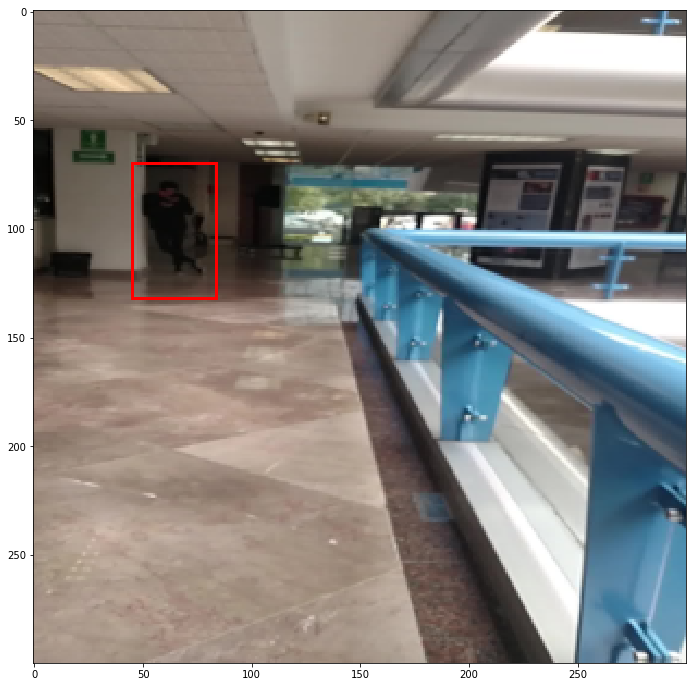

In [18]:
helper.show_image_bb(test_images_300[7], pred_voc_07_plus_12_coco_300x300_test[7])

In [8]:
np.save(path_save + 'pred_voc_07_12_300x300_test', pred_voc_07_12_300x300_test)
np.save(path_save + 'pred_voc_07_12_300x300_all', pred_voc_07_12_300x300_all)
np.save(path_save + 'pred_voc_07_12_512x512_test', pred_voc_07_12_512x512_test)
np.save(path_save + 'pred_voc_07_12_512x512_all', pred_voc_07_12_512x512_all)

np.save(path_save + 'pred_voc_07_plus_12_300x300_test', pred_voc_07_plus_12_300x300_test)
np.save(path_save + 'pred_voc_07_plus_12_300x300_all', pred_voc_07_plus_12_300x300_all)
np.save(path_save + 'pred_voc_07_plus_12_512x512_test', pred_voc_07_plus_12_512x512_test)
np.save(path_save + 'pred_voc_07_plus_12_512x512_all', pred_voc_07_plus_12_512x512_all)

np.save(path_save + 'pred_voc_07_12_coco_300x300_test', pred_voc_07_12_coco_300x300_test)
np.save(path_save + 'pred_voc_07_12_coco_300x300_all', pred_voc_07_12_coco_300x300_all)
np.save(path_save + 'pred_voc_07_12_coco_512x512_test', pred_voc_07_12_coco_512x512_test)
np.save(path_save + 'pred_voc_07_12_coco_512x512_all', pred_voc_07_12_coco_512x512_all)

np.save(path_save + 'pred_voc_07_plus_12_coco_300x300_test', pred_voc_07_plus_12_coco_300x300_test)
np.save(path_save + 'pred_voc_07_plus_12_coco_300x300_all', pred_voc_07_plus_12_coco_300x300_all)
np.save(path_save + 'pred_voc_07_plus_12_coco_512x512_test', pred_voc_07_plus_12_coco_512x512_test)
np.save(path_save + 'pred_voc_07_plus_12_coco_512x512_all', pred_voc_07_plus_12_coco_512x512_all)

In [9]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 16438525878946268705
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 1220739072
locality {
  bus_id: 1
  links {
  }
}
incarnation: 15055964744330914386
physical_device_desc: "device: 0, name: GeForce GTX 1050, pci bus id: 0000:01:00.0, compute capability: 6.1"
]
